#                              Learning to walk using policy gradient 

Name:Hasin Ishrak<br/>
Date:26-06-2019

# Policy Gradient 
The goal of reinforcement learning is to find an optimal behavior strategy for the agent to obtain optimal rewards. The policy gradient methods target at modeling and optimizing the policy directly. The policy is usually modeled with a parameterized function respect to θ, πθ(a|s). The value of the reward (objective) function depends on this policy and then various algorithms can be applied to optimize θ for the best reward.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [ ]:
import gym

# Helper functions for animation

In [ ]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [5]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [6]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames        

# Credit assignment problem Solution
If we knew what the best action was at each step, we could train the neural network as
usual, by minimizing the cross entropy between the estimated probability and the tar‐
get probability. It would just be regular supervised learning. However, in Reinforce‐
ment Learning the only guidance the agent gets is through rewards, and rewards are
typically sparse and delayed. For example, if the agent manages to balance the pole
for 100 steps, how can it know which of the 100 actions it took were good, and which
of them were bad? All it knows is that the pole fell after the last action, but surely this
last action is not entirely responsible. This is called the credit assignment problem:
when the agent gets a reward, it is hard for it to know which actions should get credi‐
ted (or blamed) for it. Think of a dog that gets rewarded hours after it behaved well;
will it understand what it is rewarded for?
To tackle this problem, a common strategy is to evaluate an action based on the sum
of all the rewards that come after it, usually applying a discount rate r at each step. For
example  if an agent decides to go right three times in a row and gets
+10 reward after the first step, 0 after the second step, and finally –50 after the third
step, then assuming we use a discount rate r = 0.8, the first action will have a total
score of $10 + r × 0 + r ^2 × (–50) = –22$. If the discount rate is close to 0, then future
rewards won’t count for much compared to immediate rewards. Conversely, if the
discount rate is close to 1, then rewards far into the future will count almost as much
as immediate rewards. Typical discount rates are 0.95 or 0.99. With a discount rate of
0.95, rewards 13 steps into the future count roughly for half as much as immediate
rewards (since $0.95^{13}$≈ 0.5), while with a discount rate of 0.99, rewards 69 steps into
the future count for half as much as immediate rewards. In the CartPole environ‐
ment, actions have fairly short-term effects, so choosing a discount rate of 0.95 seems
reasonable.

In [7]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [8]:
env = gym.make("BipedalWalker-v2")

Both works but 2nd environment takes more time to train, means more iteration.

In [ ]:
#env = gym.make("BipedalWalkerHardcore-v2")

In [9]:
obs = env.reset()

In [10]:
img = env.render(mode="rgb_array")

<IPython.core.display.Javascript object>


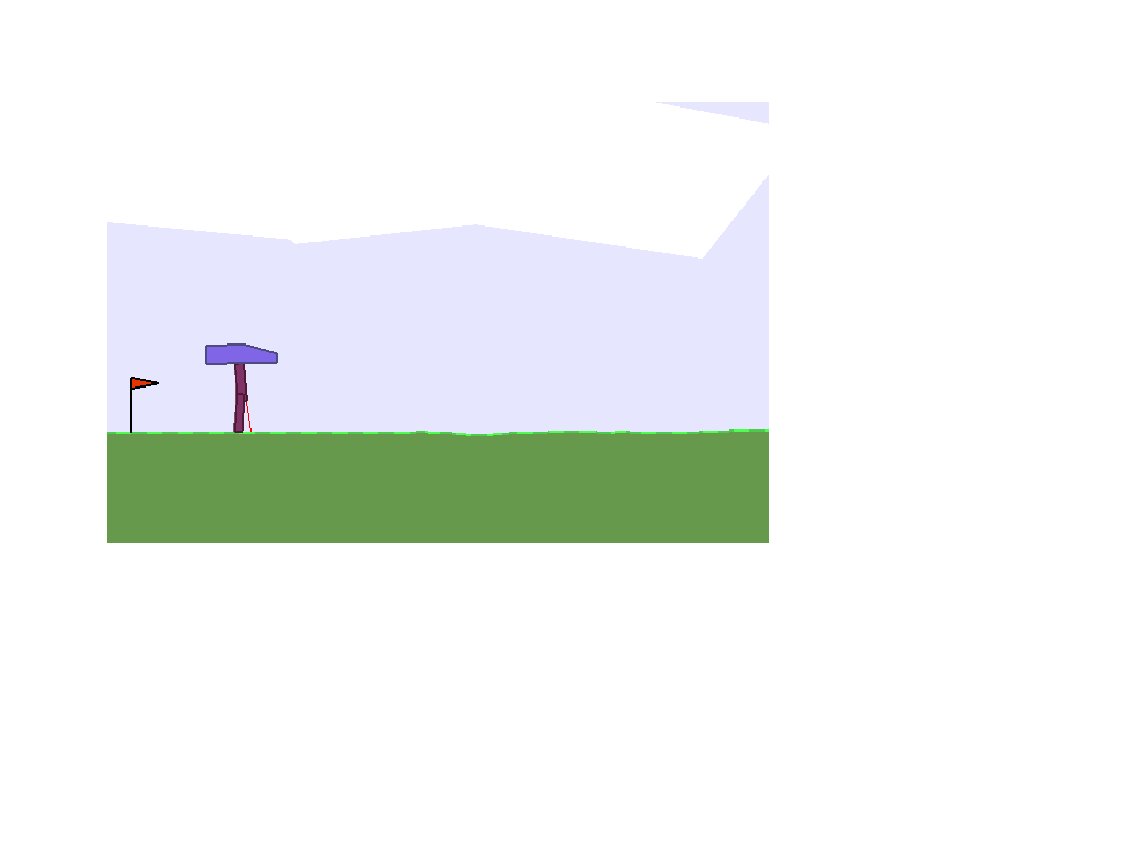

In [11]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [12]:
obs

array([ 2.74736155e-03, -1.80044561e-05,  1.40056428e-03, -1.59998775e-02,
        9.19016898e-02, -1.84826914e-03,  8.60303685e-01,  2.76860564e-03,
        1.00000000e+00,  3.23078297e-02, -1.84814131e-03,  8.53852436e-01,
        1.30711279e-03,  1.00000000e+00,  4.40814108e-01,  4.45820212e-01,
        4.61422890e-01,  4.89550292e-01,  5.34102917e-01,  6.02461159e-01,
        7.09149063e-01,  8.85932028e-01,  1.00000000e+00,  1.00000000e+00])

In [13]:
env.action_space

Box(4,)

# Discretization of Action 
his is a 4D continuous action space controling each leg's hip torque and knee torque (from -1 to 1). To deal with a continuous action space, one method is to discretize it. For example, let's limit the possible torque values to these 3 values: -1.0, 0.0, and 1.0. This means that we are left with $3^4=81$ possible actions.


In [14]:
env.action_space.low

array([-1., -1., -1., -1.], dtype=float32)

In [15]:
env.action_space.high

array([1., 1., 1., 1.], dtype=float32)

In [16]:
from itertools import product

In [17]:
possible_torques = np.array([-1.0, 0.0, 1.0])
possible_actions = np.array(list(product(possible_torques, possible_torques, possible_torques, possible_torques)))
possible_actions.shape

(81, 4)

# Architecture


In [ ]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.reset_default_graph()

# 1. Specify the network architecture
n_inputs = env.observation_space.shape[0]  # == 24
n_hidden = 10
n_outputs = len(possible_actions) # == 625
initializer = tf.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.selu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
                         kernel_initializer=initializer)
outputs = tf.nn.softmax(logits)

In [ ]:
# 3. Select a random action based on the estimated probabilities
action_index = tf.squeeze(tf.multinomial(logits, num_samples=1), axis=-1)
# 4. Training
learning_rate = 0.01
y = tf.one_hot(action_index, depth=len(possible_actions))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Agent/Player helper function

In [21]:
def run_bipedal_walker(model_path=None, n_max_steps = 1000):
    env = gym.make("BipedalWalker-v2")
    frames = []
    with tf.Session() as sess:
        if model_path is None:
            init.run()
        else:
            saver.restore(sess, model_path)
        obs = env.reset()
        for step in range(n_max_steps):
            img = env.render(mode="rgb_array")
            frames.append(img)
            action_index_val = action_index.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            action = possible_actions[action_index_val]
            obs, reward, done, info = env.step(action[0])
            if done:
                break
    env.close()
    return frames

<IPython.core.display.Javascript object>


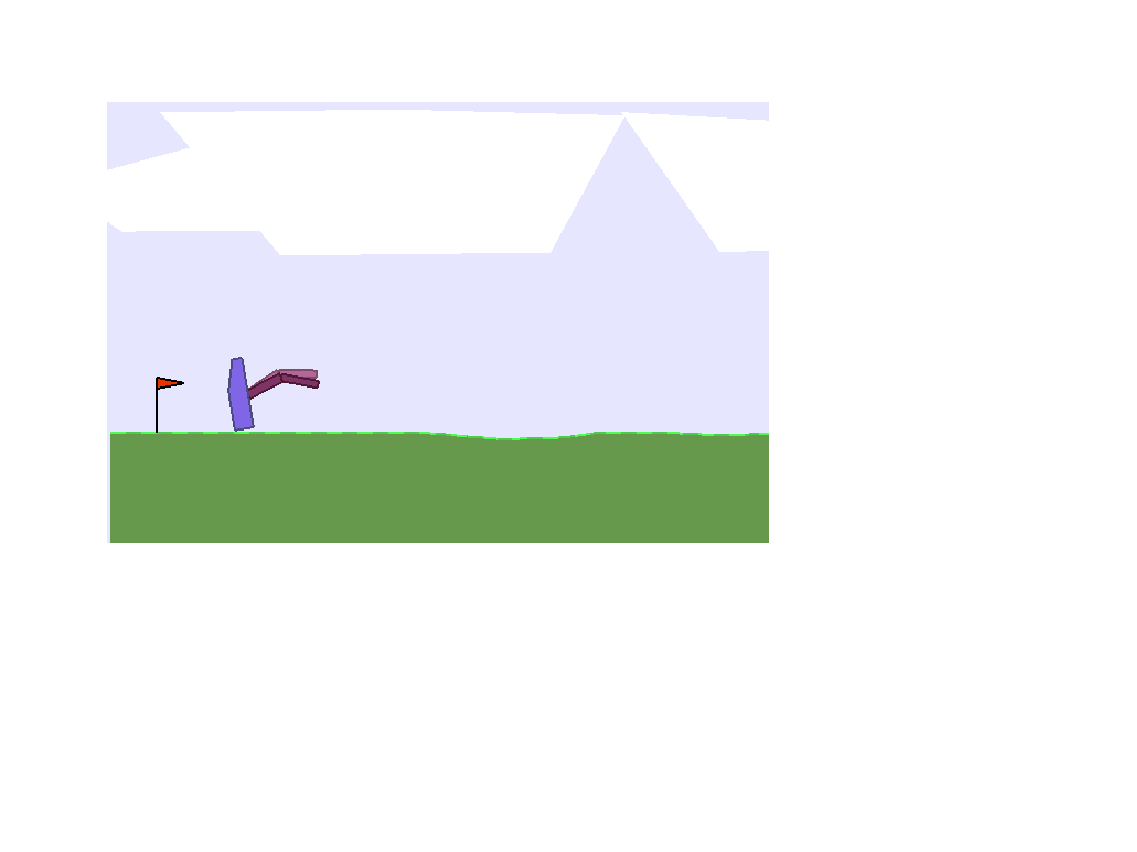

In [22]:
frames = run_bipedal_walker()
video = plot_animation(frames)
plt.show()

# Session
Discount rate is set to 0.95 and the game will be played 1000 times with only 1000 step. So the goal is to increases value or reward for 1000 games each of which played for 1000 console instructions. Besides each update requies maximum 10 games.

In [ ]:
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 1000
save_iterations = 10
discount_rate = 0.95

In [23]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}/{}".format(iteration + 1, n_iterations), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_index_val, gradients_val = sess.run([action_index, gradients],
                                                           feed_dict={X: obs.reshape(1, n_inputs)})
                action = possible_actions[action_index_val]
                obs, reward, done, info = env.step(action[0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_bipedal_walker_pg.ckpt")

Iteration: 1000/1000

INFO:tensorflow:Restoring parameters from ./my_bipedal_walker_pg.ckpt


<IPython.core.display.Javascript object>


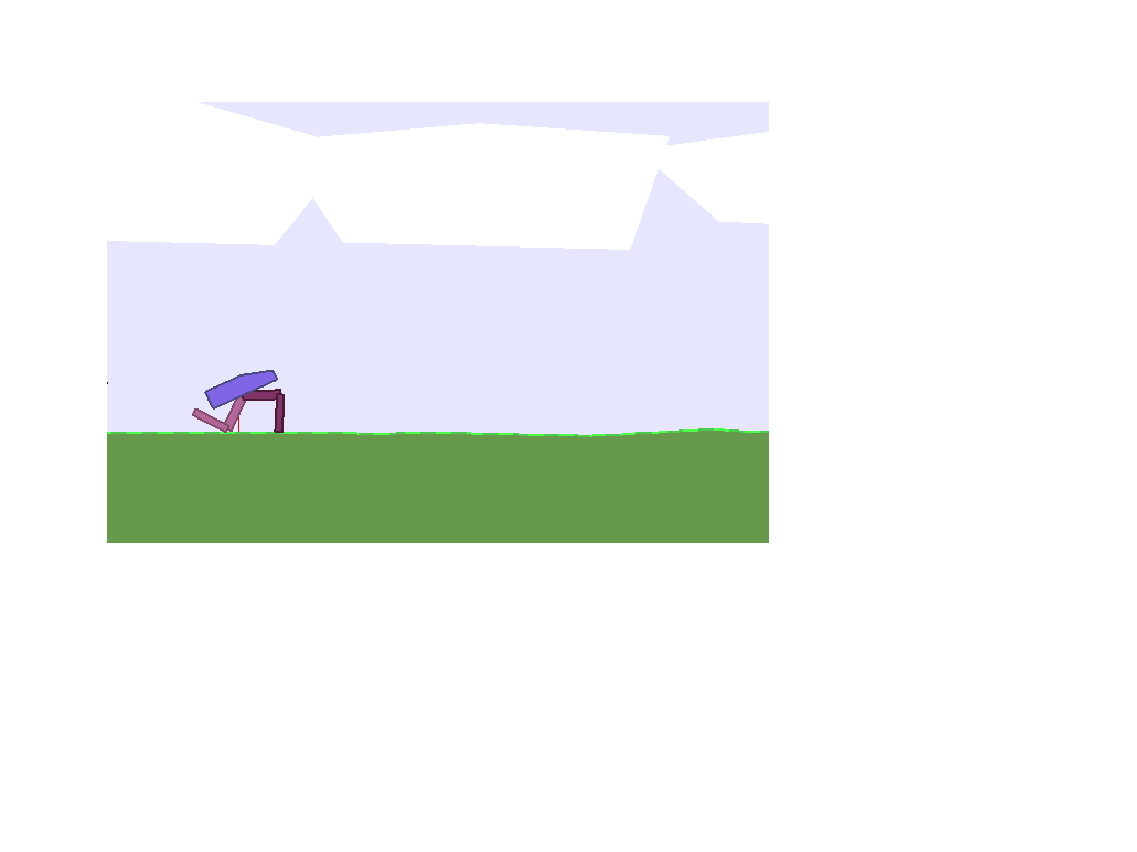

In [25]:
frames = run_bipedal_walker("./my_bipedal_walker_pg.ckpt")
video = plot_animation(frames)
plt.show()

# Discussion
1. Due to the limited resource of portable pc less iteration on training is used. So doesn't work perfectly.
2. As the number of epochs is proportional to the agent's performance.
3. Q learning might work better.
4. In RL computation limitation is very expensive so to make better agent one need more resource.

# Resource
1. Reinforcement Learning: An Introduction Book by Andrew Barto and Richard S. Sutton
2. Algorithms for Reinforcement Learning by Csaba Szepesvári
3. Reinforcement Learning: State-of-the-Art by Marco Wiering and Martijn van Otterlo 
4. Lecture CS294 Berkeley by Sergey Levine 
5. Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélien Géron